## Preparing the Data

In [63]:
%matplotlib inline

In [4]:
import glob
import string

In [5]:
path = "./data/data-for-char-rnn/names/*.txt"
file_names = glob.glob(path) # find file names: ./[Language].txt
print(file_names)
all_letters = string.ascii_letters + " .,;'"
num_letters = len(all_letters)
print(all_letters)

['./data/data-for-char-rnn/names/Scottish.txt', './data/data-for-char-rnn/names/German.txt', './data/data-for-char-rnn/names/Italian.txt', './data/data-for-char-rnn/names/Dutch.txt', './data/data-for-char-rnn/names/English.txt', './data/data-for-char-rnn/names/Portuguese.txt', './data/data-for-char-rnn/names/Chinese.txt', './data/data-for-char-rnn/names/Japanese.txt', './data/data-for-char-rnn/names/Greek.txt', './data/data-for-char-rnn/names/Vietnamese.txt', './data/data-for-char-rnn/names/Korean.txt', './data/data-for-char-rnn/names/Polish.txt', './data/data-for-char-rnn/names/Czech.txt', './data/data-for-char-rnn/names/Arabic.txt', './data/data-for-char-rnn/names/Russian.txt', './data/data-for-char-rnn/names/French.txt', './data/data-for-char-rnn/names/Irish.txt', './data/data-for-char-rnn/names/Spanish.txt']
abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'


In [6]:
import unicodedata

In [7]:
def unicode2ascii(s):
    """Turn a Unicode string to plain ASCII
    http://stackoverflow.com/a/518232/2809427"""
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [8]:
print(unicode2ascii('Ślusàrski'))

Slusarski


In [9]:
def _load_name_data(file_name):
    data = []
    with open(file_name, 'r') as f:
        for line in f:
            data.append(unicode2ascii(line.strip()))
    return data

In [10]:
file_name = './data/data-for-char-rnn/names/Chinese.txt'
data = _load_name_data(file_name)
print(data[:5])

['Ang', 'AuYong', 'Bai', 'Ban', 'Bao']


In [11]:
def load_data(file_names):
    data = dict()
    all_categories = []
    for f in file_names:
        category = f.split('/')[-1].split('.')[0]
        all_categories.append(category)
        data[category] = _load_name_data(f)
    return all_categories, data

In [66]:
all_categories, data = load_data(file_names)
num_categories = len(all_categories)
print(num_categories)
print(all_categories)
print(data['Chinese'][:5])

18
['Scottish', 'German', 'Italian', 'Dutch', 'English', 'Portuguese', 'Chinese', 'Japanese', 'Greek', 'Vietnamese', 'Korean', 'Polish', 'Czech', 'Arabic', 'Russian', 'French', 'Irish', 'Spanish']
['Ang', 'AuYong', 'Bai', 'Ban', 'Bao']


In [13]:
def letter2index(letter):
    return all_letters.find(letter)

print(letter2index('a'))

0


In [14]:
import torch

def letter2tensor(letter):
    tensor = torch.zeros(1, num_letters)
    tensor[0][letter2index(letter)] = 1
    return tensor

print(letter2tensor('a'))



Columns 0 to 12 
    1     0     0     0     0     0     0     0     0     0     0     0     0

Columns 13 to 25 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 26 to 38 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 39 to 51 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 52 to 56 
    0     0     0     0     0
[torch.FloatTensor of size 1x57]



In [16]:
def name2tensor(name):
    # [name_len, batch_size, letters_size)
    tensor = torch.zeros(len(name), 1, num_letters)
    for i, letter in enumerate(name):
        tensor[i] = letter2tensor(letter)
    return tensor

print(name2tensor('hang').size())

torch.Size([4, 1, 57])


## Define the Network: Simple RNN
![SimpleRNN](./pictures/simpleRNN.png)


In [17]:
import torch.nn as nn
from torch.autograd import Variable

In [23]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.i2o= nn.Linear(input_size + hidden_size, output_size)
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.softmax = nn.LogSoftmax()
    
    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        return self.softmax(output), hidden
    
    def init_hidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

hidden_size = 128
rnn = RNN(num_letters, hidden_size, num_category)

## Training

### Preparing for Training

In [39]:
def get_category_from_output(output):
    top_n, top_i = output.data.topk(1)
    category_index = top_i[0][0]
    return all_categories[category_index], category_index

In [40]:
x = Variable(name2tensor('hang'))
hidden = Variable(torch.zeros(1, hidden_size))

output, next_hidden = rnn(x[0], hidden)
print(output)
print(get_category_from_output(output))

Variable containing:

Columns 0 to 9 
-2.9093 -2.8742 -2.8419 -2.9471 -2.8272 -2.8358 -2.8696 -2.8296 -2.8707 -2.9160

Columns 10 to 17 
-2.9064 -2.9008 -2.8728 -2.9201 -2.9174 -2.8841 -2.9456 -2.9735
[torch.FloatTensor of size 1x18]

('English', 4)


In [26]:
import random

In [47]:
def random_choose(list_data):
    return list_data[random.randint(0, len(list_data)-1)]

In [56]:
def random_training_example(all_categories, data):
    category = random_choose(all_categories)
    name = random_choose(data[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    name_tensor = Variable(name2tensor(name))
    return category, name, category_tensor, name_tensor

for _ in range(5):
    tmp_category, tmp_name, tmp_category_tensor, tmp_name_tensor = random_training_example(all_categories, data)
    print(tmp_category, tmp_name, tmp_category_tensor.size(), tmp_name_tensor.size())

Russian Alhimenko torch.Size([1]) torch.Size([9, 1, 57])
French Simon torch.Size([1]) torch.Size([5, 1, 57])
Czech Kusak torch.Size([1]) torch.Size([5, 1, 57])
Korean Hwang torch.Size([1]) torch.Size([5, 1, 57])
Italian Passerini torch.Size([1]) torch.Size([9, 1, 57])


### Training

In [49]:
criterion = nn.NLLLoss()
learning_rate = 0.005

In [59]:
def train(category_tensor, name_tensor):
    rnn.zero_grad()
    hidden = rnn.init_hidden()
    for i in range(name_tensor.size()[0]):  # each char in name:
        output, hidden = rnn(name_tensor[i], hidden)
    loss = criterion(output, category_tensor)
    loss.backward()
    
    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)
        
    return output, loss.data[0]
    

In [60]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, name_tensor = random_training_example(all_categories, data)
    output, loss = train(category_tensor, name_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = get_category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, \
                                                time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 21s) 2.8817 Starek / Czech ✗ (Polish)
10000 10% (0m 44s) 1.2936 Achteren / Dutch ✓
15000 15% (1m 22s) 0.5757 Hatoyama / Japanese ✓
20000 20% (2m 6s) 1.1074 Ankeren / Dutch ✓
25000 25% (2m 31s) 1.8642 Gauk / Korean ✗ (Chinese)
30000 30% (3m 3s) 1.6130 Samaha / Japanese ✗ (Arabic)
35000 35% (3m 32s) 2.1473 Twine / Chinese ✗ (English)
40000 40% (3m 58s) 1.0766 Zhiznevsky / Czech ✗ (Russian)
45000 45% (4m 30s) 4.1466 Naggia / Arabic ✗ (Italian)
50000 50% (5m 0s) 0.4347 Ghanem / Arabic ✓
55000 55% (5m 23s) 5.0009 Fabian / Irish ✗ (Polish)
60000 60% (5m 51s) 0.4239 Yim / Korean ✓
65000 65% (6m 15s) 0.5626 Kuipers / Dutch ✓
70000 70% (6m 40s) 0.0028 Giannakopoulos / Greek ✓
75000 75% (7m 1s) 2.5402 Granger / French ✗ (English)
80000 80% (7m 22s) 1.8711 Fonseca / Spanish ✗ (Portuguese)
85000 85% (7m 44s) 0.4824 Ganim / Arabic ✓
90000 90% (8m 5s) 0.0210 Mcmillan / Scottish ✓
95000 95% (8m 29s) 1.0116 Gouveia / Portuguese ✓
100000 100% (8m 50s) 0.3881 Benvenuti / Italian ✓


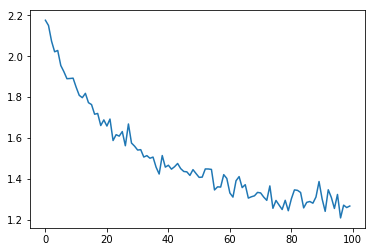

In [64]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

## Evaluating the Results

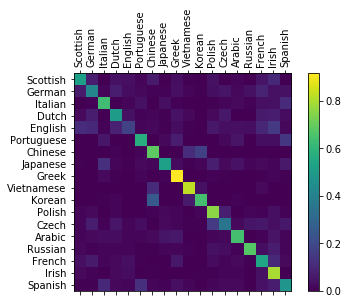

In [69]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(num_categories, num_categories)
n_confusion = 10000

# Just return an output given a name
def evaluate(name_tensor):
    hidden = rnn.init_hidden()

    for i in range(name_tensor.size()[0]):
        output, hidden = rnn(name_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, name, category_tensor, name_tensor = random_training_example(all_categories, data)
    output = evaluate(name_tensor)
    guess, guess_i = get_category_from_output(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(num_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

## Running on User Input

In [86]:
def predict(input_name, n_predictions=3):
    print('\n> %s' % input_name)
    output = evaluate(Variable(name2tensor(input_name)))

    # Get top N categories
    topv, topi = output.data.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
        value = topv[0][i]
        category_index = topi[0][i]
        print('(%.2f) %s' % (value, all_categories[category_index]))
        predictions.append([value, all_categories[category_index]])

predict('Robin')
predict('Jack Ma')
predict('Pony')


> Robin
(-1.40) Irish
(-1.93) French
(-1.94) English

> Jack Ma
(-1.23) Spanish
(-1.48) Greek
(-1.69) Czech

> Pony
(-1.24) Vietnamese
(-1.60) English
(-2.33) Italian
